In [15]:
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas._libs.tslibs.parsing import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import get_data
import os


In [16]:
file_path = os.path.join(os.getcwd(), 'dataset')
file_path

'/usr/local/keras/dataset'

In [17]:
# load dataset
# dataset = read_csv('/Users/Jackie/Desktop/mum-time/projects/ml/cashflow_prediction/dataset/user_balance_table.csv', 
#                    names=['user_id', 'tBalance', 'yBalance'], index_col=2)
dataset = get_data.GetData().get_day_balance()
dataset.to_csv(file_path+"/t_y_balance.csv")

/usr/local/keras/get_data.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  day_balance['report_date'] = pd.to_datetime(day_balance['report_date'], format=('%Y%m%d'))


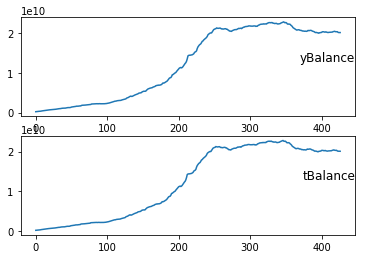

In [18]:
# load dataset
dataset = read_csv(file_path+"/t_y_balance.csv", header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [19]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv(file_path+"/t_y_balance.csv", header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[2]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)   var2(t)
1   0.000000   0.000000  0.001174
2   0.001194   0.001174  0.002119
3   0.002367   0.002119  0.002647
4   0.003311   0.002647  0.003041
5   0.003838   0.003041  0.004599


In [20]:
# split into train and test sets
values = reframed.values
n_train_hours = 280
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(280, 1, 2) (280,) (146, 1, 2) (146,)


In [21]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 280 samples, validate on 146 samples
Epoch 1/300
 - 1s - loss: 0.3219 - val_loss: 0.9012
Epoch 2/300
 - 0s - loss: 0.3044 - val_loss: 0.8724
Epoch 3/300
 - 0s - loss: 0.2879 - val_loss: 0.8424
Epoch 4/300
 - 0s - loss: 0.2723 - val_loss: 0.8122
Epoch 5/300
 - 0s - loss: 0.2581 - val_loss: 0.7821
Epoch 6/300
 - 0s - loss: 0.2452 - val_loss: 0.7524
Epoch 7/300
 - 0s - loss: 0.2334 - val_loss: 0.7231
Epoch 8/300
 - 0s - loss: 0.2237 - val_loss: 0.6953
Epoch 9/300
 - 0s - loss: 0.2159 - val_loss: 0.6686
Epoch 10/300
 - 0s - loss: 0.2086 - val_loss: 0.6426
Epoch 11/300
 - 0s - loss: 0.2019 - val_loss: 0.6172
Epoch 12/300
 - 0s - loss: 0.1956 - val_loss: 0.5923
Epoch 13/300
 - 0s - loss: 0.1896 - val_loss: 0.5677
Epoch 14/300
 - 0s - loss: 0.1836 - val_loss: 0.5434
Epoch 15/300
 - 0s - loss: 0.1778 - val_loss: 0.5192
Epoch 16/300
 - 0s - loss: 0.1721 - val_loss: 0.4952
Epoch 17/300
 - 0s - loss: 0.1666 - val_loss: 0.4714
Epoch 18/300
 - 0s - loss: 0.1612 - val_loss: 0.4477
Epoch 19/

Epoch 154/300
 - 0s - loss: 0.0035 - val_loss: 0.0068
Epoch 155/300
 - 0s - loss: 0.0035 - val_loss: 0.0066
Epoch 156/300
 - 0s - loss: 0.0035 - val_loss: 0.0066
Epoch 157/300
 - 0s - loss: 0.0034 - val_loss: 0.0065
Epoch 158/300
 - 0s - loss: 0.0034 - val_loss: 0.0064
Epoch 159/300
 - 0s - loss: 0.0034 - val_loss: 0.0064
Epoch 160/300
 - 0s - loss: 0.0034 - val_loss: 0.0064
Epoch 161/300
 - 0s - loss: 0.0034 - val_loss: 0.0063
Epoch 162/300
 - 0s - loss: 0.0034 - val_loss: 0.0060
Epoch 163/300
 - 0s - loss: 0.0034 - val_loss: 0.0058
Epoch 164/300
 - 0s - loss: 0.0034 - val_loss: 0.0058
Epoch 165/300
 - 0s - loss: 0.0034 - val_loss: 0.0057
Epoch 166/300
 - 0s - loss: 0.0033 - val_loss: 0.0057
Epoch 167/300
 - 0s - loss: 0.0033 - val_loss: 0.0057
Epoch 168/300
 - 0s - loss: 0.0033 - val_loss: 0.0056
Epoch 169/300
 - 0s - loss: 0.0033 - val_loss: 0.0055
Epoch 170/300
 - 0s - loss: 0.0033 - val_loss: 0.0050
Epoch 171/300
 - 0s - loss: 0.0033 - val_loss: 0.0050
Epoch 172/300
 - 0s - loss: 

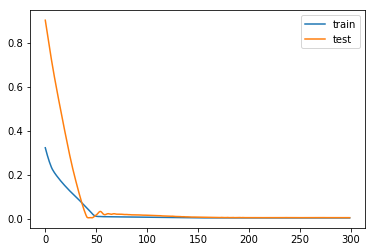

In [22]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 124680332.466


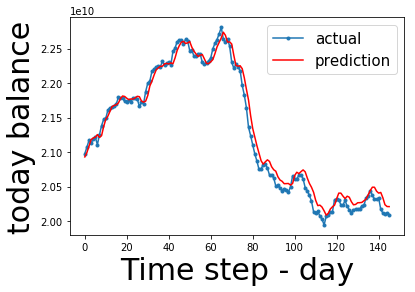

In [24]:
aa=[x for x in range(146)]
pyplot.plot(aa, inv_y[:146], marker='.', label="actual")
pyplot.plot(aa, inv_yhat[:146], 'r', label="prediction")
pyplot.ylabel('today balance', size=30)
pyplot.xlabel('Time step - day', size=30)
pyplot.legend(fontsize=15)
pyplot.show()